In [1]:
import math
import pickle
import time
import random
import numpy as np


import kmeans
import Calculate_Fitness as cf

import matplotlib.pyplot as plt
from matplotlib import figure

Objective Function Value 25.79200450147502


In [2]:
# variables
file = open("fitness_values.pickle", "rb")
fitness_values = pickle.load(file)
file.close()

solution_individuals = []
solution_costs = []

# definitions

Gene: a city (represented as (x, y) coordinates)       
Individual (aka “chromosome”): a single route satisfying the conditions above        
Population: a collection of possible routes (i.e., collection of individuals)    
Parents: two routes that are combined to create a new route         
Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)   
Fitness: a function that tells us how good each route is (in our case, how short the distance is)       
Mutation: a way to introduce variation in our population by randomly swapping two cities in a route          
Elitism: a way to carry the best individuals into the next generation      

# decisions in ga

+ Chromosome representation or coding of an individual solution   
+ Fitness function   
- Population size, generation of initial population  
+ Parent selection for reproduction  
+ Crossover operator, crossover rate/probability (pc)  
+ Mutation operator, mutation probability (pm),  
+ Forming the population for next generation  
+ Stopping (convergence) condition  

### calculate fitness 

In [3]:
def calculate_fitness(individual):
    
    def fitness(key):
        
        try:
            fitness_values[key] = cf.CalculateFitness(individual)
        except:
            return 999999.9 # if a solution is not feasible then assign its obj func
        return fitness_values[key]
    
    # key = str(list(individual.ravel()))
    key = str(individual)
    
    return fitness_values.get(key, fitness(key))

### generate initial population

In [4]:
def generate_random_array(pop_size):
    
    import pandas as pd
    
    time_horizon = 120
    
    data_consumption= pd.read_csv("miris_load_hour.csv")
    data_generation_solar = pd.read_csv("miris_PV_Hour.csv")
        
    max_consumption = data_consumption["Rounded"].max()
    max_generation_solar = data_generation_solar["Rounded"].max()
    
    upper_limit = max(max_consumption, max_generation_solar)
    lower_limit = 0 
    
    random_array = np.random.randint(lower_limit, upper_limit,  size = (pop_size, time_horizon))
    
    return random_array

In [5]:
def initialize_population(pop_size, k):

    # initial_population = np.random.randint(lower_limit, upper_limit, size=(pop_size, ind_size))
    
    points = generate_random_array(pop_size*k)
    clusters, centroids = kmeans.kmeans(points, k)

    initial_population = []

    for i in range(1,k+1):

        tmp_points = points[clusters==i]

        costs = [calculate_fitness(point) for point in tmp_points]
        
        max_idx = min(len(costs), pop_size//k)
        best_indexes = sorted(range(len(costs)), key=lambda i: costs[i])[:max_idx]
        [initial_population.append(tmp_points[idx]) for idx in best_indexes]
    
    
    if len(initial_population) < pop_size:
        initial_population = np.append(initial_population, generate_random_array(pop_size-len(initial_population)), axis=0)
    
    return np.array(initial_population)

### selection rule

In [6]:
def create_mating_pool(population, fitness_func, elitism_ratio, max_parent_allow, pop_size, choice_size=2):
        
    if fitness_func == 'distance':
        
        # calculating choice probabilities of a population based on total distance of an ind to others
        def calculate_probabilities(population):

            # calculating euclidean distance between two individual
            def calculate_distance(x, y):
                return np.sqrt(sum((x-y)**2))

            # import kmeans
            # fitness_values = [sum([kmeans.calculate_distance(ind1, ind2) for ind2 in population]) for ind1 in population]        
            fitness_values = [sum([calculate_distance(ind1, ind2) for ind2 in population]) for ind1 in population]

            total_fitness = sum(fitness_values)
            choice_probabilities = [fv/total_fitness for fv in fitness_values]   

            return choice_probabilities
    
    else:
        
        # calculating choice probabilities of a population
        def calculate_probabilities(population):

            fitness_values = [1/calculate_fitness(individual) for individual in population]
            total_fitness = sum(fitness_values)
            choice_probabilities = [fv/total_fitness for fv in fitness_values]   
            
            return choice_probabilities
    
    
    mating_pool = [] 
    # each individual can be a parent for limited times
    times_parent = np.zeros(pop_size)  
    
    # if elitism raio is greater than 0, add elite solutions to mating pool
    if elitism_ratio > 0:
        
        # determining elite solutions
        elite_individual_number = int(elitism_ratio*pop_size)
        
        costs = [calculate_fitness(individual) for individual in population]
        
        # take the individuals that has least cost values (minimization)
        best_individual_indexes = sorted(range(len(costs)), key=lambda i: costs[i])[:elite_individual_number]
        
        # adding elite solutions to the mating pool
        for i in range(0,len(best_individual_indexes),choice_size):
            parent_indexes = [best_individual_indexes[i], best_individual_indexes[i+1]]
            mating_pool.append(parent_indexes)
            times_parent[parent_indexes] += 1

    t2 = time.time() 

    # in each step 'choice_size' of parents will be chosen for number of steps
    while len(mating_pool) < pop_size//choice_size:
        
        # drawing 'choice_size' random uniform numbers
        draws = np.random.uniform(0, 1, choice_size)
        
        # index array to control parent eligibility in a population
        idx_array = np.array(range(pop_size))
        
        # an individual can be a parent if it didn't chosen as parent 'max_parent_allow*pop_size' times
        idx_array = idx_array[times_parent<int(max_parent_allow*pop_size)]
        
        parent_indexes = []
        
        # choosing an individual according to the draw probability
        for draw in draws:
           
            accumulated = 0
            
            for idx, probability in zip(idx_array, calculate_probabilities(population[idx_array])):
                
                accumulated += probability

                if draw <= accumulated:

                    parent_indexes.append(idx)
                    idx_array = idx_array[idx_array!=parent_indexes]

                    break
        
        # if the mate is not exist in the mating pool add it
        if parent_indexes not in mating_pool and parent_indexes[::-1] not in mating_pool:           

            mating_pool.append(parent_indexes)
            times_parent[parent_indexes] += 1
    
    
    return np.array([population[mate] for mate in mating_pool])

### crossover operator

In [7]:
def crossover_operator(parents, crossover_point, crossover_prob, ind_size):
    
    # make crossover with probability of crossover_probability else return parents
    draw = np.random.uniform(0, 1)
    
    if draw > crossover_prob:
        return parents

    parent_1, parent_2 = parents
        
    # choosing random two points between 1 and size of individual to determine cutpoints
    random_points = list(np.random.choice(np.arange(1,ind_size-1), crossover_point, replace=False)) 
    
    # creating start and end points of cuts
    cutpoints = sorted(random_points + [0, ind_size])
    cut_pieces = {cutpoints[i]:cutpoints[i+1] for i in range(len(cutpoints)-1)}
    
    # cutting parents from the given cut points
    parent_pcs = [(parent_1[start:end], parent_2[start:end]) for start, end in cut_pieces.items()]
    
    # crossover parents from cutpoints, n-point crossover is used (exchanging pieces from different parents)
    mask = 0
    
    offspring_1 = np.array([], dtype=int)
    offspring_2 = np.array([], dtype=int)
    
    for pcs1, pcs2 in parent_pcs:
        
        if mask%2 == 0:
            offspring_1 = np.append(offspring_1, pcs1)
            offspring_2 = np.append(offspring_2, pcs2) 
        else:
            offspring_1 = np.append(offspring_1, pcs2)
            offspring_2 = np.append(offspring_2, pcs1)
        
        mask +=1
        
    return np.array([offspring_1, offspring_2])

### mutation operator

In [8]:
def mutation_operator(offsprings, m_probability, m_rate, m_level, ind_size):
    
    mutated_offsprings = []
    
    # the number of genes will be mutated
    mutation_size = int(m_rate*ind_size)
    
    for offspring in offsprings:
        
        # mutate individuals with 'mutation_probability'
        if np.random.uniform(0, 1) < m_probability:
            
            # choose some random number to decide which genes will be mutated
            mutation_mask = np.random.choice(range(ind_size), size=mutation_size, replace=False)
            
            # determine whether or not a gene will increase or decrease by 'mutation_level' 
            mutation_multiplier = m_level*np.random.choice([-1,1], size=mutation_size, replace=True) + 1
            
            # updating genes using'mutation_mask' by 'mutation_multiplier'
            offspring[mutation_mask] = offspring[mutation_mask]*mutation_multiplier
            
            mutated_offsprings.append(offspring)
        
        else:
            mutated_offsprings.append(offspring)
            
    return np.array(mutated_offsprings)

### printing results

In [9]:
def stop_algorithm(iter_count, max_iter, run_time):
    
    results = {}

    if iter_count == max_iter:
        results['stop_cond'] = 'Max iterations'
    else:
        results['stop_cond'] = 'Convergence'
        
    
    global_min_cost = min(solution_costs)
    min_index = solution_costs.index(global_min_cost)
    global_best_solution = solution_individuals[min_index]
    
    results['iter num'] = iter_count
    results['min_cost'] = global_min_cost
    results['best_soln'] = global_best_solution
    results['cost_func'] = solution_costs
    results['run_time'] = run_time
    
    # dumping the results to a pickle object
    filehandler = open("fitness_values.pickle","wb")
    pickle.dump(fitness_values,filehandler)
    filehandler.close()
    
    return results

In [10]:
def print_results(results):
    
    print('---------------------------------------------------')
    print('Algorithm finished...')
    print()
    
    if results['stop_cond'] == 'Max iterations':
        print('Stopping condition: Max iterations reached!')
    else:
        print('Stopping condition: Convergence!')
    
    print('----------------')
    print('Best cost function: ', results['min_cost'])
    
    print('----------------')
    print('Best individual: ')
    print(results['best_soln'])
    print('----------------')  
    print('Algorithm runnig time: ', results['run_time'])
    print('----------------')
    
    plot_cost(results['cost_func'])

In [11]:
def plot_cost(costs):
    
    plt.rcParams["figure.figsize"] = (10,6)
    
    x = range(len(costs))
    y = costs

    plt.plot(x, y)
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.title('Cost Function')

### generate population

In [12]:
def run(parameters):
    
    ind_size, pop_size, k,\
    n_iter, \
    fitness_func,  cros_type, cros_probability, \
    elit_ratio, max_parent_all, \
    mut_prob, mut_rate, mut_level, \
    max_iter, stop_thrs = parameters
    
    
    # initialize generation
    
    start_time = time.time()
    
    generation = initialize_population(pop_size, k) # array
    iter_count = 0
    
    while iter_count < max_iter:
        
        # generating new population with previous population
        
        prev_generation = generation
        
        generation_list = []
        # creating mating pool
         
        mating_pool = create_mating_pool(prev_generation, fitness_func, elit_ratio, max_parent_all, pop_size)
        

        # creating new offsprings by crossover and mutation
        for mate in mating_pool: 

            offsprings = crossover_operator(mate, cros_type, cros_probability, ind_size)
            mutated_offsprings = mutation_operator(offsprings, mut_prob, mut_rate, mut_level, ind_size)
            [generation_list.append(i) for i in mutated_offsprings]
        
        generation = np.array(generation_list)
        
        
        # calculating costs of new generation
        cost_values = [calculate_fitness(individual) for individual in generation]
        
        # saving min cost and related individual obtained in this iteration
        min_itr_cost = min(cost_values)
        min_itr_index = cost_values.index(min_itr_cost)
        min_itr_individual = generation[min_itr_index]
        
        # if the last n solutions are the same then stop the algorithm
        if len(solution_costs) > stop_thrs and sum([i==min_itr_cost for i in solution_costs[-stop_thrs:]])>stop_thrs-1:
    
            break
            
        solution_individuals.append(min_itr_individual)
        solution_costs.append(min_itr_cost)
        
        iter_count +=1  
    
    finish_time = time.time()
    run_time = finish_time-start_time
    
    results = stop_algorithm(iter_count, max_iter, run_time)
    
    return results

### algorithm parameters

In [13]:
k = 10 # number of clusters in k-means
population_size = 30 

# crossover parameters
crossover_probability = 0.7
crossover_type = 1 # integer for n-point crossover
fitness_function = 'cost' # fitness function type; cost or distance based ['cost', 'distance']

# must be even!
elitism_ratio = 0.2  # percentage of best population will carry over to the next generation
max_parent_allowance = 3 # population_size//8 # maximum number of times an individual can be a parent during selection process

#mutation parameters
mutation_probability = 0.05 # probability of mutation
mutation_rate = 0.1 # rate of mutation for an individual
mutation_level = 0.3 # percentage of increase/decrease for a gene during mutation

# algorithm settings
max_iter = 500

individual_size = 120
stop_thrs = 100

### run with above parameters

In [14]:
parameters = [
                individual_size, population_size, k,\
                max_iter, \
                fitness_function,  crossover_type, crossover_probability, \
                elitism_ratio, max_parent_allowance, \
                mutation_probability, mutation_rate, mutation_level, \
                max_iter, stop_thrs
             ]

In [15]:
results = run(parameters)
results

C:\Users\IsmailKaraman\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


{'stop_cond': 'Convergence',
 'iter num': 500,
 'min_cost': 14.465967801181991,
 'best_soln': array([185, 144, 118,  83, 180, 165, 189, 218, 214, 232, 101, 371, 391,
        303,  85, 194, 288, 273, 250, 187,  93,  31, 263, 386, 336, 241,
        200, 121,  26, 140, 187, 316, 311, 431,  24,  66, 360, 182, 410,
         14,  37,  93, 300, 363, 390, 307, 253, 206, 328, 246, 183, 233,
        250, 127, 139, 158, 239, 319, 183, 309, 110, 170,  55, 254, 328,
        288, 202, 294, 263, 316, 320, 255, 199, 190, 104,  42, 112,  84,
        156, 166, 150, 431, 369,  55, 197, 227, 315, 403, 423, 413, 361,
        315, 205, 143,  62, 203, 174, 140,  53,   1,  63, 157,  56,  85,
        161, 172, 110,  88, 162, 226, 280, 209, 215, 220, 227, 185,  85,
         31,  66,  38]),
 'cost_func': [19.980159414512507,
  19.77794233312872,
  19.579311881082525,
  19.55986828859111,
  18.85672237800991,
  18.89626330305563,
  18.89626330305563,
  18.637881410303443,
  18.386743293354638,
  18.38674329335463

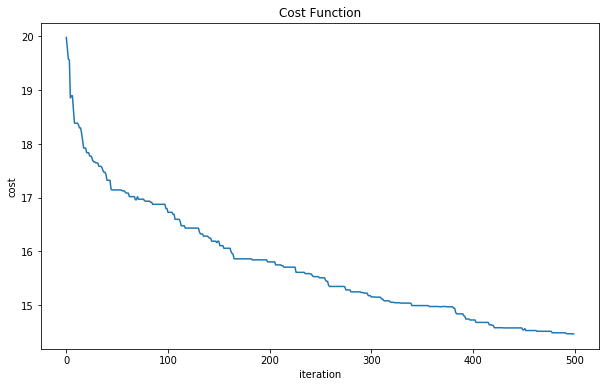

In [16]:
plot_cost(results['cost_func'])

In [18]:
2592/60

43.2